http://num.pyro.ai/en/stable/handlers.html

# Generalized Linear Model: Logistic Regression

In [1]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Generate Simulation Data

In [2]:
N, D = 3000, 3

data = random.normal(random.PRNGKey(0), (N, D))
print(f'Data: {data.shape}\n', data[:2])
true_coefs = jnp.arange(1., D + 1.)
print('True Coeff: ', true_coefs)

logits = jnp.sum(true_coefs * data, axis=-1)
labels = dist.Bernoulli(logits=logits).sample(random.PRNGKey(1))

Data: (3000, 3)
 [[ 0.16657479  0.94170254  0.11296505]
 [-1.1849517  -0.5592755  -0.04402734]]
True Coeff:  [1. 2. 3.]


Text(0, 0.5, 'label determined thru Bernoulli')

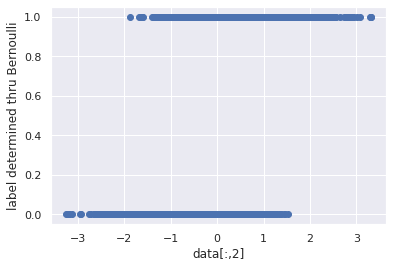

In [3]:
i = 2
plt.scatter(data[:,i], labels)
plt.xlabel(f'data[:,{i}]')
plt.ylabel(f'label determined thru Bernoulli')

## Probabilistic Modeling

Modeling:
$$
    \beta_k \sim \mathcal{N}(0, 1) \quad k=1,2,3
    \\
    \beta_0 \sim \mathcal{N}(0, 10)
    \\
    logit(p_i) = \log\frac{p}{1-p} = \beta \cdot x_i + \beta_0 , \quad x_i \in \mathbb{R}^3 \\
    \\
    y \sim \mathrm{Bernoulli}(logit)
$$
- `dist.Bernoulli()` accepts logit (or probs)

In [4]:
# do not use this. Using for-loop is very bad.
# 1. Prior Predictive Check needs another step
# 2. MCMC gets very very slow.
def logistic_regression(data, labels=None):
    coefs = numpyro.sample('coefs', dist.Normal(jnp.zeros(D), jnp.ones(D)))
    intercept = numpyro.sample('intercept', dist.Normal(0., 10.))
    for i in range(len(data)):
        logits = coefs * data[i] + intercept
        numpyro.sample(f'obs_{i}', dist.Bernoulli(logits=logits[i]), obs=labels[i])

In [5]:
# do not use this, either.
# 1. Prior Predictive Check needs another step
# 2. MCMC gets very very slow.
def logistic_regression(data, labels=None):
    coefs = numpyro.sample('coefs', dist.Normal(jnp.zeros(D), jnp.ones(D)))
    intercept = numpyro.sample('intercept', dist.Normal(0., 10.))
    logits = jnp.sum(coefs * data + intercept, axis=-1)
    for i in range(len(data)):
        numpyro.sample(f'obs_{i}', dist.Bernoulli(logits=logits[i]), obs=labels[i])

In [6]:
# vectorized, but with plate
def logistic_regression(data, labels=None):
    coefs = numpyro.sample('coefs', dist.Normal(jnp.zeros(D), jnp.ones(D)))
    intercept = numpyro.sample('intercept', dist.Normal(0., 10.))
    logits = jnp.sum(coefs * data, axis=-1)  + intercept # axis=-1: means 'along the last axis'
    with numpyro.plate('observation', len(data)):
        y = numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=labels)
    return y

In [7]:
# vectorized, implicitly, as numpyro is designed.
def logistic_regression(data, labels=None):
    coefs = numpyro.sample('coefs', dist.Normal(jnp.zeros(D), jnp.ones(D)))
    intercept = numpyro.sample('intercept', dist.Normal(0., 10.))
    logits = jnp.sum(coefs * data, axis=-1)  + intercept 
#     logits = jnp.sum(coefs * data + intercept, axis=-1)  # axis=-1: means 'along the last axis'
    y = numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=labels)

## Prior Predictive Check
- examine the distribution of the model without data

In [8]:
p = Predictive(logistic_regression, num_samples=1500)
prior_predict = p(random.PRNGKey(11), data)

In [9]:
prior_predict.keys()

dict_keys(['coefs', 'intercept', 'obs'])

In [10]:
prior_predict['coefs'].shape, prior_predict['obs'].shape

((1500, 3), (1500, 3000))

Text(0.5, 1.0, 'intercept')

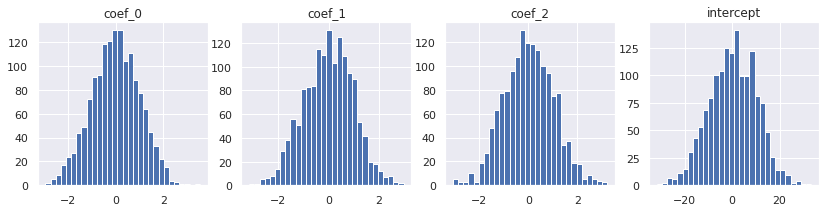

In [11]:
fig, axes = plt.subplots(1,4, figsize=(14,3))
for i, ax in enumerate(axes[:-1]):
    ax.hist(prior_predict['coefs'][:,i], bins=30);
    ax.set_title(f'coef_{i}')
axes[-1].hist(prior_predict['intercept'], bins=30)
axes[-1].set_title('intercept')

In [12]:
_, counts = jnp.unique(prior_predict['obs'].ravel(), return_counts=True)
counts / len(prior_predict['obs'].ravel())

DeviceArray([0.48236066, 0.51763934], dtype=float32)

## MCMC inference

In [13]:
num_warmup, num_samples = 1000, 2000
mcmc = MCMC(NUTS(model=logistic_regression), num_warmup, num_samples)
mcmc.run(random.PRNGKey(2), data, labels)  
mcmc.print_summary()  

sample: 100%|██████████| 3000/3000 [00:05<00:00, 527.32it/s, 7 steps of size 5.56e-01. acc. prob=0.92]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   coefs[0]      0.97      0.07      0.97      0.86      1.08   1477.85      1.00
   coefs[1]      2.06      0.09      2.06      1.89      2.20   1315.31      1.00
   coefs[2]      3.19      0.13      3.19      2.98      3.40   1093.15      1.00
  intercept     -0.08      0.06     -0.09     -0.18      0.01   1748.45      1.00

Number of divergences: 0


### Explore the result of inference

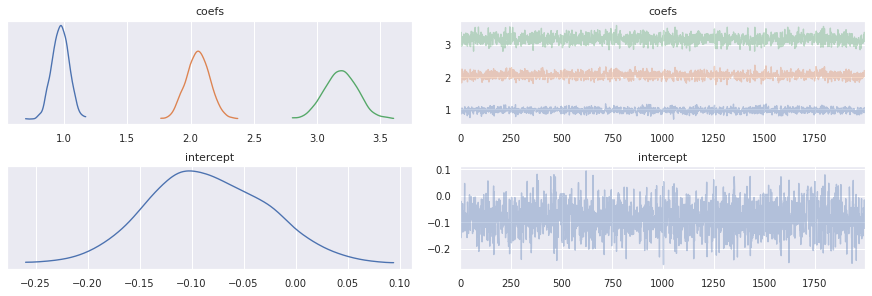

In [15]:
import arviz
trace = arviz.from_numpyro(mcmc)
arviz.plot_trace(trace);

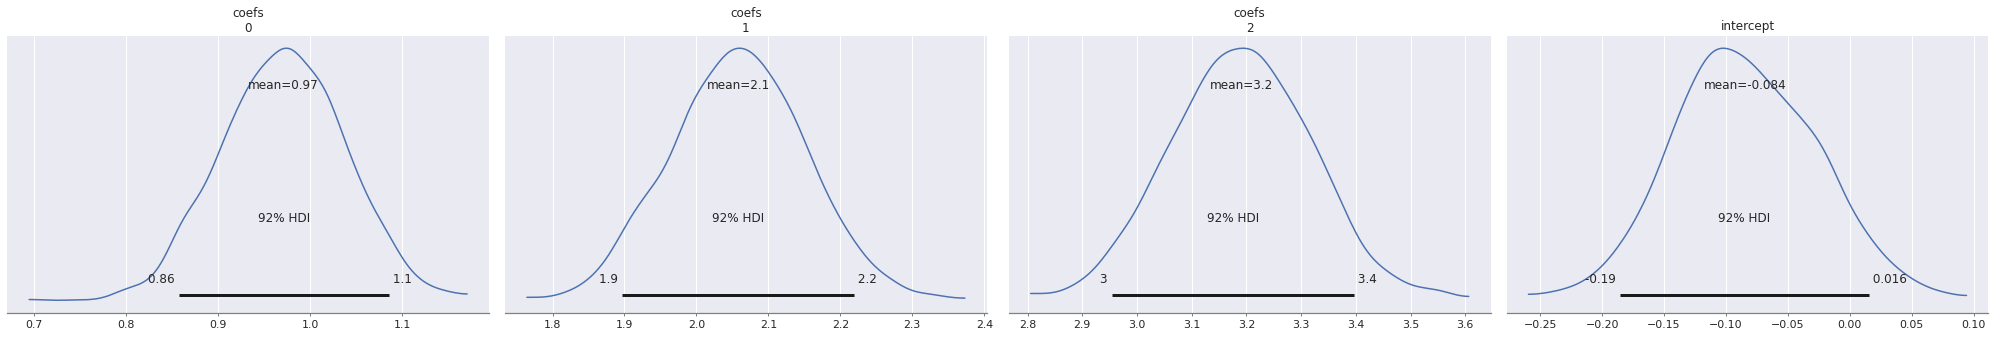

In [16]:
arviz.plot_posterior(trace, hdi_prob=.92);

### Posterior Predictive Check

In [17]:
p = Predictive(logistic_regression, posterior_samples=mcmc.get_samples())
posterior_predict = p(random.PRNGKey(11), data)

In [18]:
posterior_predict['obs'].shape

(2000, 3000)

[0.77 0.   0.   0.   0.   0.   0.   0.   0.   9.23]


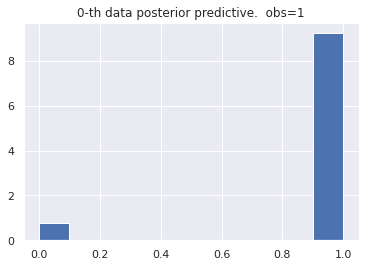

In [19]:
i = 0
r = plt.hist(posterior_predict['obs'][:,i], density=True)
plt.title(f'{i}-th data posterior predictive.  obs={labels[0]}');
print(r[0])

This observation data has a large probability of having label 1 and very small for 0.

## Log Likelihood

The log_likelihood function uses effect handlers to run the model by substituting sample sites with values from the posterior distribution and computes the log density for a single data point. The log_predictive_density function computes the log likelihood for each draw from the joint posterior and aggregates the results for all the data points, but does so by using JAX’s auto-vectorize transform called vmap so that we do not need to loop over all the data points.

In [20]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.substitute(handlers.seed(model, rng_key), params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])

def log_predictive_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return jnp.sum(logsumexp(log_lk_vals, 0) - jnp.log(n))

print(log_predictive_density(random.PRNGKey(2), 
                             mcmc.get_samples(),
                             logistic_regression, 
                             data, labels)) 
# -874.89813

-874.89764


뚱.